In [17]:
''' camera calibration with aruco markers
'''
import cv2
from cv2 import aruco
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle

def gen_dir(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))

References:
https://www.cxymm.net/article/dgut_guangdian/107814300
https://edwardize.blogspot.com/2021/03/python-opencvaruco-camera-calibration.html 
https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html

In [12]:
data_root = os.path.abspath('../')
dataset = 'charuco_images3'
img_dir = data_root + '/images/{}'.format(dataset)
res_dir = data_root + '/results/aruco_{}'.format(dataset)
gen_dir(img_dir)
gen_dir(res_dir)
img_names = os.listdir(img_dir)
print('number of images: {}'.format(len(img_names)))

number of images: 16


image: IMG_0188.png, (3024, 4032, 3)
detected markers 8
corners of one marker [[[ 998. 2590.]
  [ 980. 2312.]
  [1264. 2298.]
  [1282. 2577.]]]
(32, 2)


True

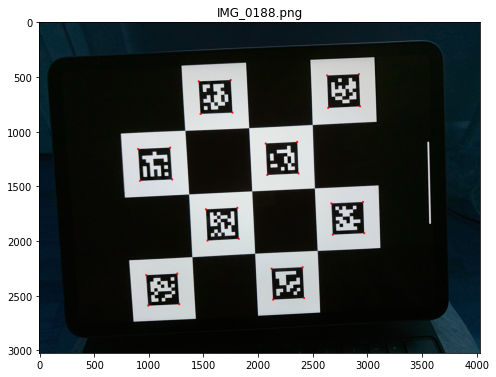

In [13]:
'''test aruco marker detection'''
index = 0
img_name = img_names[index]
img_file = img_dir + '/' + img_name
img = cv2.imread(img_file, flags = cv2.IMREAD_COLOR)
print('image: {}, {}'.format(img_name, img.shape))

aruco_dict = aruco.Dictionary_get(cv2.aruco.DICT_7X7_250)
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(img, aruco_dict)
print('detected markers {}'.format(len(corners)))
print('corners of one marker {}'.format(corners[0]))

## visualize the detected corners
rows, cols, size = 1, 1, 7
fig = plt.figure(tight_layout=True,figsize=(size*cols, size*rows))
ax = fig.subplots(nrows = rows, ncols = cols)
img_path = img_file
rad = 8
point_arr = np.array(corners)
point_arr = point_arr.squeeze()
point_arr = point_arr.reshape(-1, 2)
print(point_arr.shape)
for i in range(point_arr.shape[0]):
    p = point_arr[i]
    yi, xi = p[0], p[1]
    xi, yi = int(xi), int(yi)
    img[xi - rad: xi + rad + 1, yi - rad: yi + rad + 1, 1:] = 0 
    img[xi - rad: xi + rad + 1, yi - rad: yi + rad + 1, 0] = 255
ax.imshow(img)
ax.set_title(os.path.basename(img_file))
res_file = res_dir + '/charcuo_det.png'
cv2.imwrite(res_file, img)

In [41]:
''' calibration with a set of images'''
CHARUCOBOARD_COLCOUNT = 4
CHARUCOBOARD_ROWCOUNT = 4
board = cv2.aruco.CharucoBoard_create(
        squaresX=CHARUCOBOARD_COLCOUNT,
        squaresY=CHARUCOBOARD_ROWCOUNT,
        squareLength=0.025,
        markerLength=0.0125,
        dictionary=aruco_dict)
image_board = board.draw((200 * CHARUCOBOARD_ROWCOUNT, 200 * CHARUCOBOARD_COLCOUNT))
cv2.imwrite(res_dir + '/aruco_board.png', image_board)

# detect all corners in the images
all_corners = []
all_ids = []
rad = 16
det_dir = res_dir + '/det_dir'
gen_dir(det_dir)
for i, fn in enumerate(img_names):
    print(fn)
    img_file = img_dir + '/{}'.format(fn)
    img = cv2.imread(img_file, flags = cv2.IMREAD_GRAYSCALE)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(img, aruco_dict)
    # print(len(corners), len(ids))
    # print(ids)
    if len(corners) > 0:
        res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, img, board)
        if res2[1] is not None and res2[2] is not None and len(res2[1]) > 3:
                all_corners.append(res2[1])
                all_ids.append(res2[2])
                # print(res2[2])
                print(len(res2[1][0]), len(res2[-1]))
                for corner in res2[1]:
                    xi, yi = corner[0]
                    yi, xi = int(yi), int(xi)
                    img[yi - rad: yi + rad + 1, xi - rad: xi + rad + 1] = 0
        cv2.aruco.drawDetectedMarkers(img, corners, ids)
    res_file = det_dir + '/det_{}'.format(fn)
    cv2.imwrite(res_file, img)
print(len(all_corners))
# calibration
try:
    cal = cv2.aruco.calibrateCameraCharuco(all_corners, all_ids, board, img.shape, None, None)
except:
    print("Calibrationcould not be done ...")
# Get the calibration result:
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cal
# Save the camera parameters:
# with open('calibration2.pckl', 'w+') as f:
#     pickle.dump((cameraMatrix, distCoeffs), f)
print('camera matrix: {}'.format(cameraMatrix))
print('distortion coefficients: {}'.format(distCoeffs))

IMG_0188.png
1 9
IMG_0189.png
1 9
IMG_0182.png
1 9
IMG_0183.png
1 9
IMG_0181.png
1 9
IMG_0194.png
1 9
IMG_0180.png
1 9
IMG_0184.png
1 9
IMG_0190.png
1 9
IMG_0191.png
1 9
IMG_0185.png
1 9
IMG_0193.png
1 9
IMG_0187.png
1 9
IMG_0186.png
1 9
IMG_0192.png
1 9
IMG_0179.png
1 9
16
camera matrix: [[7.71207609e+03 0.00000000e+00 2.14172498e+03]
 [0.00000000e+00 7.85641360e+03 2.68422682e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients: [[ 6.04704928e-01  1.58427851e+00  9.83782321e-02  6.15747294e-03
  -1.49994242e+01]]


In [44]:
ch_corners = board.chessboardCorners
print(len(ch_corners), ch_corners[0])

9 [0.025 0.025 0.   ]


In [50]:
'''Reprojection error for one image'''
obj_points = board.chessboardCorners
print(obj_points)
obj_ids = [i for i in range(len(obj_points))]
# obj_res = cv2.aruco.interpolateCornersCharuco(obj_points, ids, img, board)
print(len(obj_points), len(obj_points[0]))
tot_error = 0
tot_points = 0
for i in range(len(all_corners)):
    corners = all_corners[i]
    # print(corners.shape)
    ids = all_ids[i]
    points = obj_points[ids]
    print('object points: {}'.format(len(points)))
    reprojected_points, _ = cv2.projectPoints(points, rvecs[i], tvecs[i], cameraMatrix, distCoeffs)
    print('reprojected points: {}'.format(len(reprojected_points)))
    corners = corners.reshape((-1, 2))
    reprojected_points = reprojected_points.reshape((-1, 2))
    print(corners.shape, reprojected_points.shape)
    tot_error += cv2.norm(corners, reprojected_points, cv2.NORM_L2)/len(corners)
    # tot_err += np.sum(np.abs(img_points[i]-reprojected_points)**2)
    tot_points += len(points)
mean_err = tot_error * 1. / tot_points
print(mean_err)
# img_index = 0
# img_name = img_names[img_index]
# img_file = img_dir + '/{}'.format(img_name)
# img = cv2.imread(img_file, flags = cv2.IMREAD_GRAYSCALE)
# corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(img, aruco_dict)
# if len(corners) > 0:
#     res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, img, board)
# new_corners = res2[1]
# new_ids = res2[2]
# corn_map = {}
# tot_error = 0
# tot_points = 0
# for i in range(new_ids):
#     corn_map[new_ids[i]] = new_corners
#     points = obj_points[new_ids[i]]
#     reprojected_points, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs)

# tot_error = 0
# total_points = 0
# for i in range(len(obj_points)):
#     reprojected_points, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs)
#     reprojected_points=reprojected_points.reshape(-1,2)
#     tot_error+=np.sum(np.abs(img_points[i]-reprojected_points)**2)
#     total_points+=len(obj_points[i])

[[0.025 0.025 0.   ]
 [0.05  0.025 0.   ]
 [0.075 0.025 0.   ]
 [0.025 0.05  0.   ]
 [0.05  0.05  0.   ]
 [0.075 0.05  0.   ]
 [0.025 0.075 0.   ]
 [0.05  0.075 0.   ]
 [0.075 0.075 0.   ]]
9 3
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object points: 9
reprojected points: 9
(9, 2) (9, 2)
object poin